In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import os
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout,LSTM

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import datetime
from datetime import date, timedelta
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')

data_path = 'D:/universidad/universidad 4/TFG/recursos para el desarrollo/datos procesados/OD'

In [2]:
delta = e_date - i_date

target_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    target_days.append(day)

In [3]:
def read_OD_fn(source_type):
    ods = {}
    for date in tqdm_notebook(target_days):
        od_date= pd.read_csv(os.path.join(data_path, 'date_{}_OD_{}.csv'.format(source_type,date.strftime('%Y-%m-%d'))), 
                            index_col=0)
        ods[date] = od_date
    return ods

In [4]:
ine_ods = read_OD_fn('INE')

  0%|          | 0/81 [00:00<?, ?it/s]

# Serializar los datos

In [5]:
lista_ine1 = []
lista_ine2 = []
lista_ine3 = []
lista_ine4 = []
lista_ine5 = []

for date in tqdm_notebook(target_days):
    lista_ine1.append(ine_ods[date].loc['58MA','total'])
    lista_ine2.append(ine_ods[date].loc['156B','total'])
    lista_ine3.append(ine_ods[date].loc['34CZ','total'])
    lista_ine4.append(ine_ods[date].loc['165V','total'])
    lista_ine5.append(ine_ods[date].loc['13VI','total'])

  0%|          | 0/81 [00:00<?, ?it/s]

In [6]:
df_ine1 = pd.DataFrame (lista_ine1, columns = ['Viajes'], index= target_days)
df_ine2 = pd.DataFrame (lista_ine2, columns = ['Viajes'], index= target_days)
df_ine3 = pd.DataFrame (lista_ine3, columns = ['Viajes'], index= target_days)
df_ine4 = pd.DataFrame (lista_ine4, columns = ['Viajes'], index= target_days)
df_ine5 = pd.DataFrame (lista_ine5, columns = ['Viajes'], index= target_days)

In [7]:
lista_ine = []

df = df_ine1 + df_ine2 + df_ine3 + df_ine4 + df_ine5

In [8]:
df.head()

,Viajes
2020-04-01,16278
2020-04-02,16895
2020-04-03,18153
2020-04-04,13180
2020-04-05,11805


In [9]:
del ine_ods

# Visualización de datos

In [10]:
print(df.index.min())
print(df.index.max())

2020-04-01 00:00:00
2020-06-20 00:00:00


In [11]:
print(len(df['2020']))

81


In [12]:
df.describe()

,Viajes
count,81.000000
mean,30777.061728
std,13658.229593
min,10416.000000
25%,18843.000000
50%,30457.000000
75%,42480.000000
max,55828.000000


In [13]:
meses = df.resample('M').mean()
meses

,Viajes
2020-04-30,18261.733333
2020-05-31,32278.387097
2020-06-30,47223.000000


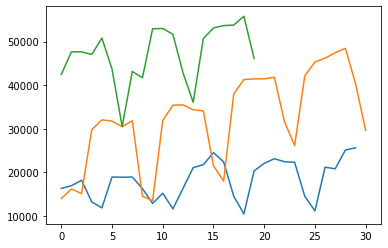

In [14]:
abril = df['2020-04-01':'2020-04-30']
plt.plot(abril.values)
mayo = df['2020-05-01':'2020-05-31']
plt.plot(mayo.values)
junio = df['2020-06-01':'2020-06-20']
plt.plot(junio.values)

# Preprocesado de datos

In [15]:
dataset = df.values
dataset = dataset.astype('float32')

In [16]:
# normalizamos el conjunto de datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Dividimos los datos en sets de entrenamiento y validacion

In [17]:
#dividimos nuestros valores entre sets de entrenamiento y de test
n_train_days = 60
train = dataset[:n_train_days, :]
test = dataset[n_train_days:, :]

print(len(train), len(test))

60 21


In [18]:
# funcion para convertir un array de valores en una matriz de conjuntos de datos
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [19]:
# dividimos en entradas y salidas
look_back = 7

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(len(trainX), len(testY))

53 14


In [20]:
print(trainX)

[[0.12908483 0.14267153 0.17037347 0.06086496 0.03058663 0.18677881
  0.18556768]
 [0.14267153 0.17037347 0.06086496 0.03058663 0.18677881 0.18556768
  0.18671277]
 [0.17037347 0.06086496 0.03058663 0.18677881 0.18556768 0.18671277
  0.12793976]
 [0.06086496 0.03058663 0.18677881 0.18556768 0.18671277 0.12793976
  0.05317977]
 [0.03058663 0.18677881 0.18556768 0.18671277 0.12793976 0.05317977
  0.10444376]
 [0.18677881 0.18556768 0.18671277 0.12793976 0.05317977 0.10444376
  0.02567604]
 [0.18556768 0.18671277 0.12793976 0.05317977 0.10444376 0.02567604
  0.1293931 ]
 [0.18671277 0.12793976 0.05317977 0.10444376 0.02567604 0.1293931
  0.23418918]
 [0.12793976 0.05317977 0.10444376 0.02567604 0.1293931  0.23418918
  0.24907511]
 [0.05317977 0.10444376 0.02567604 0.1293931  0.23418918 0.24907511
  0.31002817]
 [0.10444376 0.02567604 0.1293931  0.23418918 0.24907511 0.31002817
  0.26323438]
 [0.02567604 0.1293931  0.23418918 0.24907511 0.31002817 0.26323438
  0.08909538]
 [0.1293931  0.23

In [21]:
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [22]:
print(trainX)

[[[0.12908483]
  [0.14267153]
  [0.17037347]
  [0.06086496]
  [0.03058663]
  [0.18677881]
  [0.18556768]]

 [[0.14267153]
  [0.17037347]
  [0.06086496]
  [0.03058663]
  [0.18677881]
  [0.18556768]
  [0.18671277]]

 [[0.17037347]
  [0.06086496]
  [0.03058663]
  [0.18677881]
  [0.18556768]
  [0.18671277]
  [0.12793976]]

 [[0.06086496]
  [0.03058663]
  [0.18677881]
  [0.18556768]
  [0.18671277]
  [0.12793976]
  [0.05317977]]

 [[0.03058663]
  [0.18677881]
  [0.18556768]
  [0.18671277]
  [0.12793976]
  [0.05317977]
  [0.10444376]]

 [[0.18677881]
  [0.18556768]
  [0.18671277]
  [0.12793976]
  [0.05317977]
  [0.10444376]
  [0.02567604]]

 [[0.18556768]
  [0.18671277]
  [0.12793976]
  [0.05317977]
  [0.10444376]
  [0.02567604]
  [0.1293931 ]]

 [[0.18671277]
  [0.12793976]
  [0.05317977]
  [0.10444376]
  [0.02567604]
  [0.1293931 ]
  [0.23418918]]

 [[0.12793976]
  [0.05317977]
  [0.10444376]
  [0.02567604]
  [0.1293931 ]
  [0.23418918]
  [0.24907511]]

 [[0.05317977]
  [0.10444376]
  [0.02

In [23]:
print(trainY)

[0.18671277 0.12793976 0.05317977 0.10444376 0.02567604 0.1293931
 0.23418918 0.24907511 0.31002817 0.26323438 0.08909538 0.
 0.21734342 0.25565928 0.27919933 0.2640932  0.2611204  0.08898529
 0.01559059 0.23639125 0.2282216  0.32315245 0.33438298 0.07749054
 0.12613407 0.10285828 0.42594466 0.47579935 0.46945742 0.44131508
 0.47130713 0.08935964 0.06632608 0.47229806 0.5499207  0.5517484
 0.52682114 0.5209416  0.24343786 0.16645381 0.6077689  0.67957807
 0.68307936 0.68316746 0.6916013  0.46597818 0.34607592 0.69827354
 0.76862943 0.78765523 0.8153131  0.83762    0.6593411 ]


# Creamos la red neuronal

In [24]:
def crear_modeloFF():
    model = Sequential() 
    model.add(LSTM(20, input_shape=(look_back,1), return_sequences=True))
    model.add(LSTM(50, input_shape=(look_back,1), return_sequences=True))
    model.add(Dropout(0.30))
    model.add(LSTM(100, input_shape=(look_back,1)))
    model.add(Dropout(0.30))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    return model

In [25]:
model = crear_modeloFF()

history=model.fit(trainX, trainY, epochs=200, validation_data=(testX,testY), batch_size=1, verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 20)             1760      
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 50)             14200     
_________________________________________________________________
dropout (Dropout)            (None, 7, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 76,461
Trainable params: 76,461
Non-trainable params: 0
____________________________________________________

Epoch 123/200
53/53 - 0s - loss: 0.0114 - val_loss: 0.0273
Epoch 124/200
53/53 - 0s - loss: 0.0121 - val_loss: 0.0188
Epoch 125/200
53/53 - 0s - loss: 0.0129 - val_loss: 0.0350
Epoch 126/200
53/53 - 0s - loss: 0.0124 - val_loss: 0.0191
Epoch 127/200
53/53 - 0s - loss: 0.0128 - val_loss: 0.0196
Epoch 128/200
53/53 - 0s - loss: 0.0103 - val_loss: 0.0177
Epoch 129/200
53/53 - 0s - loss: 0.0109 - val_loss: 0.0274
Epoch 130/200
53/53 - 0s - loss: 0.0124 - val_loss: 0.0189
Epoch 131/200
53/53 - 0s - loss: 0.0106 - val_loss: 0.0217
Epoch 132/200
53/53 - 0s - loss: 0.0087 - val_loss: 0.0178
Epoch 133/200
53/53 - 0s - loss: 0.0114 - val_loss: 0.0169
Epoch 134/200
53/53 - 0s - loss: 0.0097 - val_loss: 0.0166
Epoch 135/200
53/53 - 0s - loss: 0.0087 - val_loss: 0.0187
Epoch 136/200
53/53 - 0s - loss: 0.0095 - val_loss: 0.0179
Epoch 137/200
53/53 - 0s - loss: 0.0090 - val_loss: 0.0186
Epoch 138/200
53/53 - 0s - loss: 0.0109 - val_loss: 0.0147
Epoch 139/200
53/53 - 0s - loss: 0.0088 - val_loss: 0.03

# Visualizamos resultados

In [26]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


def compute_metrics_fn(y_valid_resc, y_hat_resc):
    mae_ = mean_absolute_error(y_valid_resc, y_hat_resc)
    mse_ = mean_squared_error(y_valid_resc, y_hat_resc)
    rmse_ = mean_squared_error(y_valid_resc, y_hat_resc, squared = False)
    cvrmse_ = rmse_/np.mean(y_valid_resc)*100 # it is a percentage
    mape_ = mape(y_valid_resc, y_hat_resc)
    
    return mae_, mse_, rmse_, cvrmse_, mape_

In [27]:
# hacemos las predicciones
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invertimos las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY_scalerInverse = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_scalerInverse = scaler.inverse_transform([testY])

In [28]:
# calculamos las metricas de error
trainScore_MAE, trainScore_MSE, trainScore_RMSE, trainScore_CVRMSE, trainScore_MAPE  =  compute_metrics_fn(trainY_scalerInverse[0], trainPredict[:,0])
print('Resultado del entrenamiento: %.2f MAE' % (trainScore_MAE))
print('Resultado del entrenamiento: %.2f MSE' % (trainScore_MSE))
print('Resultado del entrenamiento: %.2f RMSE' % (trainScore_RMSE))
print('Resultado del entrenamiento: %.2f CVRMSE' % (trainScore_CVRMSE))
print('Resultado del entrenamiento: %.2f MAPE \n' % (trainScore_MAPE))

testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(testY_scalerInverse[0], testPredict[:,0])
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del entrenamiento: 3166.38 MAE
Resultado del entrenamiento: 14310506.71 MSE
Resultado del entrenamiento: 3782.92 RMSE
Resultado del entrenamiento: 14.27 CVRMSE
Resultado del entrenamiento: 14.69 MAPE 

Resultado del test: 4600.95 MAE
Resultado del test: 34533209.32 MSE
Resultado del test: 5876.50 RMSE
Resultado del test: 12.37 CVRMSE
Resultado del test: 11.36 MAPE


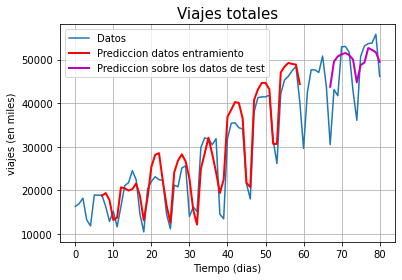

In [29]:
# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# predicciones del test de cambio para plotear
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset), :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(testPredictPlot,'m', linewidth = 2)
plt.legend( ('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc = 'upper left')
plt.grid(True)
plt.title("Viajes totales", fontsize = 15)
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.show()

In [30]:
results=testPredict
print(len(results))

14


In [31]:
testResults = testY_scalerInverse[0]

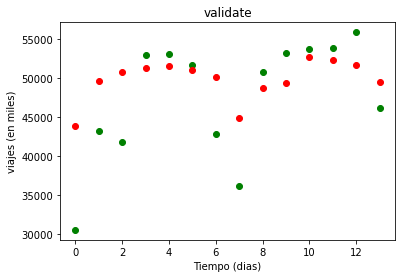

In [32]:
plt.scatter(range(len(testResults)),testResults,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.show()

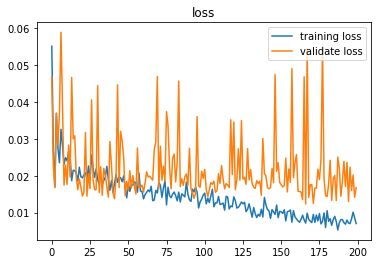

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.legend( ('training loss', 'validate loss'), loc = 'upper right')
plt.show()

In [34]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

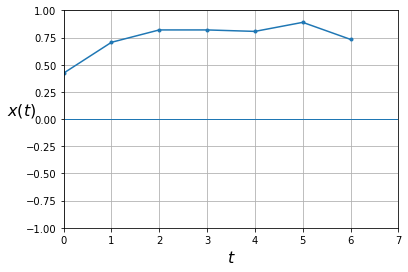

In [35]:
n_steps = 6 #preguntar
plot_series(testX[0, :, 0], testY_scalerInverse[0, 0], testPredict[0, 0])
plt.show()

# Exportar los datos

In [36]:
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-06-07', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(testPredict, index= index_days)
prediccion.columns = ['valor predicho']

prediccion

,valor predicho
2020-06-07,43757.808594
2020-06-08,49579.882812
2020-06-09,50736.925781
2020-06-10,51219.000000
2020-06-11,51527.722656
2020-06-12,51025.941406
2020-06-13,50027.562500
2020-06-14,44790.933594
2020-06-15,48736.714844
2020-06-16,49321.511719


In [37]:
datosReales = df['2020-6-07':'2020-6-20']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']

compara

,real,prediccion
2020-06-07,30490,43757.808594
2020-06-08,43136,49579.882812
2020-06-09,41698,50736.925781
2020-06-10,52941,51219.000000
2020-06-11,53023,51527.722656
2020-06-12,51677,51025.941406
2020-06-13,42811,50027.562500
2020-06-14,36064,44790.933594
2020-06-15,50699,48736.714844
2020-06-16,53129,49321.511719


In [38]:
compara.to_excel('Resultados INE.xlsx', columns=['real', 'prediccion'])

# Prediccion a futuro

In [39]:
# usaremos 7 dias que poseemos para predecir los 7 dias siguientes tras esto compararemos los resultados con los que
# poseemos para ver el grado de error

Dias = df['2020-5-25':'2020-5-31']

In [40]:
# funcion para convertir un array de valores en una matriz de conjuntos de datos, en este caso modificada para ayudarnos a crear
#los distintos sets de entrenmiento para distintos modelos que predeciran 1 dia cada uno

def create_dataset2(dataset, look_back=1, dias=0):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-dias):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back + dias, 0])
  return np.array(dataX), np.array(dataY)

In [41]:
#ahora crearemos los sets para entrenar los modelos
look_back = 7

trainX1, trainY1 = create_dataset2(train, look_back, 1)
testX1, testY1 = create_dataset2(test, look_back, 1)

trainX2, trainY2 = create_dataset2(train, look_back, 2)
testX2, testY2 = create_dataset2(test, look_back, 2)

trainX3, trainY3 = create_dataset2(train, look_back, 3)
testX3, testY3 = create_dataset2(test, look_back, 3)

trainX4, trainY4 = create_dataset2(train, look_back, 4)
testX4, testY4 = create_dataset2(test, look_back, 4)

trainX5, trainY5 = create_dataset2(train, look_back, 5)
testX5, testY5 = create_dataset2(test, look_back, 5)

trainX6, trainY6 = create_dataset2(train, look_back, 6)
testX6, testY6 = create_dataset2(test, look_back, 6)

In [42]:
print(trainX1)

[[0.12908483 0.14267153 0.17037347 0.06086496 0.03058663 0.18677881
  0.18556768]
 [0.14267153 0.17037347 0.06086496 0.03058663 0.18677881 0.18556768
  0.18671277]
 [0.17037347 0.06086496 0.03058663 0.18677881 0.18556768 0.18671277
  0.12793976]
 [0.06086496 0.03058663 0.18677881 0.18556768 0.18671277 0.12793976
  0.05317977]
 [0.03058663 0.18677881 0.18556768 0.18671277 0.12793976 0.05317977
  0.10444376]
 [0.18677881 0.18556768 0.18671277 0.12793976 0.05317977 0.10444376
  0.02567604]
 [0.18556768 0.18671277 0.12793976 0.05317977 0.10444376 0.02567604
  0.1293931 ]
 [0.18671277 0.12793976 0.05317977 0.10444376 0.02567604 0.1293931
  0.23418918]
 [0.12793976 0.05317977 0.10444376 0.02567604 0.1293931  0.23418918
  0.24907511]
 [0.05317977 0.10444376 0.02567604 0.1293931  0.23418918 0.24907511
  0.31002817]
 [0.10444376 0.02567604 0.1293931  0.23418918 0.24907511 0.31002817
  0.26323438]
 [0.02567604 0.1293931  0.23418918 0.24907511 0.31002817 0.26323438
  0.08909538]
 [0.1293931  0.23

In [43]:
print(trainY1)

[0.12793976 0.05317977 0.10444376 0.02567604 0.1293931  0.23418918
 0.24907511 0.31002817 0.26323438 0.08909538 0.         0.21734342
 0.25565928 0.27919933 0.2640932  0.2611204  0.08898529 0.01559059
 0.23639125 0.2282216  0.32315245 0.33438298 0.07749054 0.12613407
 0.10285828 0.42594466 0.47579935 0.46945742 0.44131508 0.47130713
 0.08935964 0.06632608 0.47229806 0.5499207  0.5517484  0.52682114
 0.5209416  0.24343786 0.16645381 0.6077689  0.67957807 0.68307936
 0.68316746 0.6916013  0.46597818 0.34607592 0.69827354 0.76862943
 0.78765523 0.8153131  0.83762    0.6593411 ]


In [44]:
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]

trainX1 = np.reshape(trainX1, (trainX1.shape[0], trainX1.shape[1], 1))
testX1 = np.reshape(testX1, (testX1.shape[0], testX1.shape[1], 1))

trainX2 = np.reshape(trainX2, (trainX2.shape[0], trainX2.shape[1], 1))
testX2 = np.reshape(testX2, (testX2.shape[0], testX2.shape[1], 1))

trainX3 = np.reshape(trainX3, (trainX3.shape[0], trainX3.shape[1], 1))
testX3 = np.reshape(testX3, (testX3.shape[0], testX3.shape[1], 1))

trainX4 = np.reshape(trainX4, (trainX4.shape[0], trainX4.shape[1], 1))
testX4 = np.reshape(testX4, (testX4.shape[0], testX4.shape[1], 1))

trainX5 = np.reshape(trainX5, (trainX5.shape[0], trainX5.shape[1], 1))
testX5 = np.reshape(testX5, (testX5.shape[0], testX5.shape[1], 1))

trainX6 = np.reshape(trainX6, (trainX6.shape[0], trainX6.shape[1], 1))
testX6 = np.reshape(testX6, (testX6.shape[0], testX6.shape[1], 1))

In [45]:
#creamos los distintos modelos para predecir cada dia

model1 = crear_modeloFF()
history=model1.fit(trainX1, trainY1, epochs=200, validation_data=(testX1,testY1), batch_size=1, verbose=2)

model2 = crear_modeloFF()
history=model2.fit(trainX2, trainY2, epochs=200, validation_data=(testX2,testY2), batch_size=1, verbose=2)

model3 = crear_modeloFF()
history=model3.fit(trainX3, trainY3, epochs=200, validation_data=(testX3,testY3), batch_size=1, verbose=2)

model4 = crear_modeloFF()
history=model4.fit(trainX4, trainY4, epochs=200, validation_data=(testX4,testY4), batch_size=1, verbose=2)

model5 = crear_modeloFF()
history=model5.fit(trainX5, trainY5, epochs=200, validation_data=(testX5,testY5), batch_size=1, verbose=2)

model6 = crear_modeloFF()
history=model6.fit(trainX6, trainY6, epochs=200, validation_data=(testX6,testY6), batch_size=1, verbose=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 7, 20)             1760      
_________________________________________________________________
lstm_4 (LSTM)                (None, 7, 50)             14200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 76,461
Trainable params: 76,461
Non-trainable params: 0
__________________________________________________

52/52 - 0s - loss: 0.0104 - val_loss: 0.0142
Epoch 123/200
52/52 - 0s - loss: 0.0105 - val_loss: 0.0179
Epoch 124/200
52/52 - 0s - loss: 0.0089 - val_loss: 0.0173
Epoch 125/200
52/52 - 0s - loss: 0.0088 - val_loss: 0.0253
Epoch 126/200
52/52 - 0s - loss: 0.0123 - val_loss: 0.0177
Epoch 127/200
52/52 - 0s - loss: 0.0099 - val_loss: 0.0143
Epoch 128/200
52/52 - 0s - loss: 0.0117 - val_loss: 0.0115
Epoch 129/200
52/52 - 0s - loss: 0.0105 - val_loss: 0.0136
Epoch 130/200
52/52 - 0s - loss: 0.0102 - val_loss: 0.0113
Epoch 131/200
52/52 - 0s - loss: 0.0097 - val_loss: 0.0144
Epoch 132/200
52/52 - 0s - loss: 0.0093 - val_loss: 0.0305
Epoch 133/200
52/52 - 0s - loss: 0.0124 - val_loss: 0.0117
Epoch 134/200
52/52 - 0s - loss: 0.0103 - val_loss: 0.0122
Epoch 135/200
52/52 - 0s - loss: 0.0099 - val_loss: 0.0131
Epoch 136/200
52/52 - 0s - loss: 0.0092 - val_loss: 0.0115
Epoch 137/200
52/52 - 0s - loss: 0.0096 - val_loss: 0.0148
Epoch 138/200
52/52 - 0s - loss: 0.0116 - val_loss: 0.0117
Epoch 139/2

Epoch 43/200
51/51 - 0s - loss: 0.0113 - val_loss: 0.0172
Epoch 44/200
51/51 - 0s - loss: 0.0112 - val_loss: 0.0214
Epoch 45/200
51/51 - 0s - loss: 0.0124 - val_loss: 0.0111
Epoch 46/200
51/51 - 0s - loss: 0.0136 - val_loss: 0.0156
Epoch 47/200
51/51 - 0s - loss: 0.0134 - val_loss: 0.0099
Epoch 48/200
51/51 - 0s - loss: 0.0117 - val_loss: 0.0147
Epoch 49/200
51/51 - 0s - loss: 0.0125 - val_loss: 0.0229
Epoch 50/200
51/51 - 0s - loss: 0.0106 - val_loss: 0.0113
Epoch 51/200
51/51 - 0s - loss: 0.0119 - val_loss: 0.0096
Epoch 52/200
51/51 - 0s - loss: 0.0131 - val_loss: 0.0308
Epoch 53/200
51/51 - 0s - loss: 0.0112 - val_loss: 0.0122
Epoch 54/200
51/51 - 0s - loss: 0.0112 - val_loss: 0.0144
Epoch 55/200
51/51 - 0s - loss: 0.0104 - val_loss: 0.0109
Epoch 56/200
51/51 - 0s - loss: 0.0092 - val_loss: 0.0141
Epoch 57/200
51/51 - 0s - loss: 0.0098 - val_loss: 0.0101
Epoch 58/200
51/51 - 0s - loss: 0.0159 - val_loss: 0.0113
Epoch 59/200
51/51 - 0s - loss: 0.0132 - val_loss: 0.0264
Epoch 60/200
5

Epoch 183/200
51/51 - 0s - loss: 0.0087 - val_loss: 0.0183
Epoch 184/200
51/51 - 0s - loss: 0.0089 - val_loss: 0.0156
Epoch 185/200
51/51 - 0s - loss: 0.0070 - val_loss: 0.0154
Epoch 186/200
51/51 - 0s - loss: 0.0105 - val_loss: 0.0150
Epoch 187/200
51/51 - 0s - loss: 0.0099 - val_loss: 0.0167
Epoch 188/200
51/51 - 0s - loss: 0.0079 - val_loss: 0.0145
Epoch 189/200
51/51 - 0s - loss: 0.0103 - val_loss: 0.0141
Epoch 190/200
51/51 - 0s - loss: 0.0094 - val_loss: 0.0138
Epoch 191/200
51/51 - 0s - loss: 0.0113 - val_loss: 0.0149
Epoch 192/200
51/51 - 0s - loss: 0.0093 - val_loss: 0.0142
Epoch 193/200
51/51 - 0s - loss: 0.0080 - val_loss: 0.0155
Epoch 194/200
51/51 - 0s - loss: 0.0093 - val_loss: 0.0151
Epoch 195/200
51/51 - 0s - loss: 0.0095 - val_loss: 0.0150
Epoch 196/200
51/51 - 0s - loss: 0.0100 - val_loss: 0.0176
Epoch 197/200
51/51 - 0s - loss: 0.0106 - val_loss: 0.0140
Epoch 198/200
51/51 - 0s - loss: 0.0093 - val_loss: 0.0160
Epoch 199/200
51/51 - 0s - loss: 0.0089 - val_loss: 0.02

50/50 - 0s - loss: 0.0093 - val_loss: 0.0159
Epoch 105/200
50/50 - 0s - loss: 0.0092 - val_loss: 0.0124
Epoch 106/200
50/50 - 0s - loss: 0.0090 - val_loss: 0.0148
Epoch 107/200
50/50 - 0s - loss: 0.0103 - val_loss: 0.0197
Epoch 108/200
50/50 - 0s - loss: 0.0100 - val_loss: 0.0211
Epoch 109/200
50/50 - 0s - loss: 0.0091 - val_loss: 0.0182
Epoch 110/200
50/50 - 0s - loss: 0.0103 - val_loss: 0.0191
Epoch 111/200
50/50 - 0s - loss: 0.0090 - val_loss: 0.0127
Epoch 112/200
50/50 - 0s - loss: 0.0105 - val_loss: 0.0142
Epoch 113/200
50/50 - 0s - loss: 0.0092 - val_loss: 0.0141
Epoch 114/200
50/50 - 0s - loss: 0.0112 - val_loss: 0.0235
Epoch 115/200
50/50 - 0s - loss: 0.0103 - val_loss: 0.0128
Epoch 116/200
50/50 - 0s - loss: 0.0090 - val_loss: 0.0141
Epoch 117/200
50/50 - 0s - loss: 0.0108 - val_loss: 0.0171
Epoch 118/200
50/50 - 0s - loss: 0.0129 - val_loss: 0.0151
Epoch 119/200
50/50 - 0s - loss: 0.0081 - val_loss: 0.0194
Epoch 120/200
50/50 - 0s - loss: 0.0101 - val_loss: 0.0128
Epoch 121/2

49/49 - 0s - loss: 0.0139 - val_loss: 0.0545
Epoch 25/200
49/49 - 0s - loss: 0.0170 - val_loss: 0.1720
Epoch 26/200
49/49 - 0s - loss: 0.0160 - val_loss: 0.2040
Epoch 27/200
49/49 - 0s - loss: 0.0177 - val_loss: 0.1078
Epoch 28/200
49/49 - 0s - loss: 0.0202 - val_loss: 0.0170
Epoch 29/200
49/49 - 0s - loss: 0.0204 - val_loss: 0.0090
Epoch 30/200
49/49 - 0s - loss: 0.0180 - val_loss: 0.0096
Epoch 31/200
49/49 - 0s - loss: 0.0161 - val_loss: 0.0216
Epoch 32/200
49/49 - 0s - loss: 0.0161 - val_loss: 0.0176
Epoch 33/200
49/49 - 0s - loss: 0.0137 - val_loss: 0.0232
Epoch 34/200
49/49 - 0s - loss: 0.0127 - val_loss: 0.0229
Epoch 35/200
49/49 - 0s - loss: 0.0142 - val_loss: 0.0595
Epoch 36/200
49/49 - 0s - loss: 0.0144 - val_loss: 0.1455
Epoch 37/200
49/49 - 0s - loss: 0.0181 - val_loss: 0.0186
Epoch 38/200
49/49 - 0s - loss: 0.0185 - val_loss: 0.0542
Epoch 39/200
49/49 - 0s - loss: 0.0155 - val_loss: 0.0265
Epoch 40/200
49/49 - 0s - loss: 0.0129 - val_loss: 0.0402
Epoch 41/200
49/49 - 0s - l

Epoch 165/200
49/49 - 0s - loss: 0.0084 - val_loss: 0.0105
Epoch 166/200
49/49 - 0s - loss: 0.0096 - val_loss: 0.0073
Epoch 167/200
49/49 - 0s - loss: 0.0092 - val_loss: 0.0124
Epoch 168/200
49/49 - 0s - loss: 0.0103 - val_loss: 0.0131
Epoch 169/200
49/49 - 0s - loss: 0.0110 - val_loss: 0.0073
Epoch 170/200
49/49 - 0s - loss: 0.0086 - val_loss: 0.0134
Epoch 171/200
49/49 - 0s - loss: 0.0107 - val_loss: 0.0100
Epoch 172/200
49/49 - 0s - loss: 0.0093 - val_loss: 0.0090
Epoch 173/200
49/49 - 0s - loss: 0.0087 - val_loss: 0.0086
Epoch 174/200
49/49 - 0s - loss: 0.0085 - val_loss: 0.0105
Epoch 175/200
49/49 - 0s - loss: 0.0084 - val_loss: 0.0129
Epoch 176/200
49/49 - 0s - loss: 0.0103 - val_loss: 0.0098
Epoch 177/200
49/49 - 0s - loss: 0.0102 - val_loss: 0.0136
Epoch 178/200
49/49 - 0s - loss: 0.0098 - val_loss: 0.0080
Epoch 179/200
49/49 - 0s - loss: 0.0086 - val_loss: 0.0101
Epoch 180/200
49/49 - 0s - loss: 0.0096 - val_loss: 0.0054
Epoch 181/200
49/49 - 0s - loss: 0.0113 - val_loss: 0.01

Epoch 86/200
48/48 - 0s - loss: 0.0085 - val_loss: 0.0247
Epoch 87/200
48/48 - 0s - loss: 0.0101 - val_loss: 0.0086
Epoch 88/200
48/48 - 0s - loss: 0.0132 - val_loss: 0.0133
Epoch 89/200
48/48 - 0s - loss: 0.0121 - val_loss: 0.0174
Epoch 90/200
48/48 - 0s - loss: 0.0103 - val_loss: 0.0318
Epoch 91/200
48/48 - 0s - loss: 0.0113 - val_loss: 0.0240
Epoch 92/200
48/48 - 0s - loss: 0.0117 - val_loss: 0.0089
Epoch 93/200
48/48 - 0s - loss: 0.0109 - val_loss: 0.0205
Epoch 94/200
48/48 - 0s - loss: 0.0105 - val_loss: 0.0104
Epoch 95/200
48/48 - 0s - loss: 0.0117 - val_loss: 0.0168
Epoch 96/200
48/48 - 0s - loss: 0.0089 - val_loss: 0.0308
Epoch 97/200
48/48 - 0s - loss: 0.0114 - val_loss: 0.0196
Epoch 98/200
48/48 - 0s - loss: 0.0106 - val_loss: 0.0164
Epoch 99/200
48/48 - 0s - loss: 0.0109 - val_loss: 0.0143
Epoch 100/200
48/48 - 0s - loss: 0.0080 - val_loss: 0.0141
Epoch 101/200
48/48 - 0s - loss: 0.0107 - val_loss: 0.0204
Epoch 102/200
48/48 - 0s - loss: 0.0104 - val_loss: 0.0177
Epoch 103/2

Epoch 6/200
47/47 - 0s - loss: 0.0335 - val_loss: 0.0621
Epoch 7/200
47/47 - 0s - loss: 0.0405 - val_loss: 0.0516
Epoch 8/200
47/47 - 0s - loss: 0.0391 - val_loss: 0.0233
Epoch 9/200
47/47 - 0s - loss: 0.0566 - val_loss: 0.0368
Epoch 10/200
47/47 - 0s - loss: 0.0444 - val_loss: 0.0228
Epoch 11/200
47/47 - 0s - loss: 0.0392 - val_loss: 0.0308
Epoch 12/200
47/47 - 0s - loss: 0.0349 - val_loss: 0.0597
Epoch 13/200
47/47 - 0s - loss: 0.0407 - val_loss: 0.0314
Epoch 14/200
47/47 - 0s - loss: 0.0349 - val_loss: 0.0230
Epoch 15/200
47/47 - 0s - loss: 0.0395 - val_loss: 0.0583
Epoch 16/200
47/47 - 0s - loss: 0.0395 - val_loss: 0.0329
Epoch 17/200
47/47 - 0s - loss: 0.0320 - val_loss: 0.0245
Epoch 18/200
47/47 - 0s - loss: 0.0340 - val_loss: 0.0221
Epoch 19/200
47/47 - 0s - loss: 0.0300 - val_loss: 0.0277
Epoch 20/200
47/47 - 0s - loss: 0.0305 - val_loss: 0.0683
Epoch 21/200
47/47 - 0s - loss: 0.0268 - val_loss: 0.0218
Epoch 22/200
47/47 - 0s - loss: 0.0366 - val_loss: 0.0288
Epoch 23/200
47/47

Epoch 147/200
47/47 - 0s - loss: 0.0082 - val_loss: 0.0137
Epoch 148/200
47/47 - 0s - loss: 0.0093 - val_loss: 0.0081
Epoch 149/200
47/47 - 0s - loss: 0.0085 - val_loss: 0.0096
Epoch 150/200
47/47 - 0s - loss: 0.0083 - val_loss: 0.0136
Epoch 151/200
47/47 - 0s - loss: 0.0090 - val_loss: 0.0162
Epoch 152/200
47/47 - 0s - loss: 0.0093 - val_loss: 0.0120
Epoch 153/200
47/47 - 0s - loss: 0.0085 - val_loss: 0.0234
Epoch 154/200
47/47 - 0s - loss: 0.0074 - val_loss: 0.0335
Epoch 155/200
47/47 - 0s - loss: 0.0087 - val_loss: 0.0118
Epoch 156/200
47/47 - 0s - loss: 0.0087 - val_loss: 0.0217
Epoch 157/200
47/47 - 0s - loss: 0.0089 - val_loss: 0.0140
Epoch 158/200
47/47 - 0s - loss: 0.0071 - val_loss: 0.0174
Epoch 159/200
47/47 - 0s - loss: 0.0089 - val_loss: 0.0132
Epoch 160/200
47/47 - 0s - loss: 0.0073 - val_loss: 0.0137
Epoch 161/200
47/47 - 0s - loss: 0.0099 - val_loss: 0.0192
Epoch 162/200
47/47 - 0s - loss: 0.0089 - val_loss: 0.0059
Epoch 163/200
47/47 - 0s - loss: 0.0088 - val_loss: 0.01

# Preparamos los datos para el test

In [46]:
# cargamos el dataframe en la variable dataset
dataset = Dias.values

# convertimos los enteros en floats
dataset = dataset.astype('float32')

# normalizamos los datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [47]:
#remodelamos los datos
testX = np.reshape(dataset, (1, 7, 1))

# Predicciones para la proxima semana

In [48]:
results = []

parcial=model.predict(testX)
results.append(parcial[0])

parcial=model1.predict(testX)
results.append(parcial[0])

parcial=model2.predict(testX)
results.append(parcial[0])

parcial=model3.predict(testX)
results.append(parcial[0])

parcial=model4.predict(testX)
results.append(parcial[0])

parcial=model5.predict(testX)
results.append(parcial[0])

parcial=model6.predict(testX)
results.append(parcial[0])

results = np.reshape(results, (7, 1))
print(results)

[[0.8027878 ]
 [0.80461824]
 [0.82818747]
 [0.9602968 ]
 [1.0628082 ]
 [0.8166138 ]
 [0.3141904 ]]


# Re-Convertimos los resultados

In [49]:
inverted = scaler.inverse_transform(results)

#en nuestro problema no tienen sentido los decimales pues no se pueden hacer 0.5 viajes o 0.25 viajes
inverted = inverted.round()
inverted = inverted.astype(int)

inverted

array([[44736],
       [44770],
       [45214],
       [47705],
       [49638],
       [44996],
       [35523]])

# Visualizamos el pronostico

<AxesSubplot:>

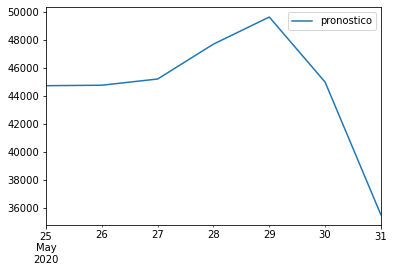

In [50]:
e_date = datetime.datetime.strptime('2020-05-31', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-05-25', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(inverted, index= index_days)
prediccion.columns = ['pronostico']
prediccion.plot()

In [51]:
datosReales = df['2020-5-25':'2020-5-31']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']

compara

,real,prediccion
2020-05-25,42126,44736
2020-05-26,45321,44770
2020-05-27,46185,45214
2020-05-28,47441,47705
2020-05-29,48454,49638
2020-05-30,40358,44996
2020-05-31,29599,35523


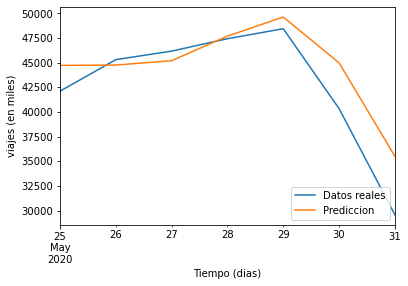

In [52]:
compara['real'].plot()
compara['prediccion'].plot()
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.legend( ('Datos reales', 'Prediccion'), loc = 'lower right')

In [53]:
# calculamos las metricas de error
testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(prediccion, datosReales)
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del test: 2306.00 MAE
Resultado del test: 9447844.86 MSE
Resultado del test: 3073.73 RMSE
Resultado del test: 6.88 CVRMSE
Resultado del test: 5.59 MAPE
